#  March Machine Learning Mania 2025

#### Author: Adrián Ulises Ramírez Barajas
#### Date: 10/03/2025
#### Data Source: https://www.kaggle.com/competitions/march-machine-learning-mania-2025/data

The NCAA Division I men's basketball tournament, branded as March Madness, is a single-elimination tournament played in the United States to determine the men's college basketball national champion of the Division I level in the National Collegiate Athletic Association (NCAA) [1]. Played mostly during March, the tournament consists of 68 teams and was first conducted in 1939. Known for its upsets of favored teams, it has become one of the biggest annual sporting events in the US[1].

In this project, we participate in the Kaggle competition "March Machine Learning Mania 2025", where we develop a machine learning model trained on historical NCAA game data to forecast the outcomes of the Division I men's and women's basketball tournaments.


The goal is to predict the probabilities for each possible match that team with ID_1 wins over team ID_2, where ID_1 < ID_2. This is a binary classification problem, where the target variable is is t = {0, 1}.  Specifically, t=1 when the team with ID1 defeats the team with ID2 (where ID1 < ID2), and t=0 otherwise. The metric used is the Brier score, which measures the accuracy of predicted probabilities compared to actual game outcomes.

The dataset consists of multiple tables, including both compact and detailed results of historical regular-season and NCAA tournament games. We load these tables into a local PostgreSQL database using the Python library SQLAlchemy and perform feature engineering to construct our training set.

Next, we evaluate the performance of several machine learning algorithms, including logistic regression, decision trees, random forests, and gradient boosting, all implemented using the scikit-learn library. Since the data is time-ordered, standard cross-validation is not appropriate for evaluating model performance. To address this, we implement the SeasonalCrossValidation class. Additionally, we use RandomizedGridSearch to optimize the hyperparameters for each model.

The best-performing model in our tests is logistic regression. Finally, we train the model on the entire dataset and generate probability predictions for all possible matchups. Our model's performance will be assessed using the results of the upcoming NCAA 2025 tournament.


Techniques and software used:
    - python (numpy, pandas, matplotlib, scikit-learn, sqlalchemy)
    - postgresql (database loading, queries, subqueries, aggregation functions, temporary tables, functions,
                  windows, rolling averages, common table expressions)
    - logistic regression, decision trees, random forest, gradient boosting.

## Part 1: Loading Data and and Exploratory Analysis

In [10]:
# Libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy import text
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sqlalchemy import text
import csv
from pathlib import Path
import opendatasets as od

In [6]:
# Configure pandas to show all dataframe´s columns
pd.set_option('display.max_columns', None)

In [7]:
# Connecting to postgresql database using create_engine from sqlalchemy
# Credentials
db_user = "postgres"
db_password = "****"
db_port = "5432"
db_host = "localhost"
db_name = "NCAA2025"
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Test conection
with engine.connect() as connection:
    print("Conexión exitosa a postgresql")

Conexión exitosa a postgresql


In [13]:
# Download dataset
od.download( "https://www.kaggle.com/competitions/march-machine-learning-mania-2025/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adrinulisesramrez
Your Kaggle Key: ········


  0%|                                                                                      | 0.00/34.0M [00:00<?, ?B/s]

100%|█████████████████████████████████████████████████████████████████████████████| 34.0M/34.0M [00:13<00:00, 2.61MB/s]



Extracting archive .\march-machine-learning-mania-2025/march-machine-learning-mania-2025.zip to .\march-machine-learning-mania-2025


In [19]:
# Working directory
project_path = ".\\march-machine-learning-mania-2025\\"
 
#Check if a string can be converted to an integer type
def to_int32_or_object(string):
    try:
        int(string)
        return 'int32'
    except:
        return 'object'

#Ignore files
ignore_files = ["SeedBenchmarkStage1.csv","MMasseyOrdinals.csv","SampleSubmissionStage1.csv",
                "SampleSubmissionStage2.csv"]

# Load tables in postgresql database
for filename in os.listdir(project_path):
    if filename.endswith('.csv') and filename not in ignore_files:
        column_names = []
        data_types = {}
        table_name = os.path.splitext(filename)[0]
        file_path = os.path.join(project_path, filename)
        # Obtain a dictionary with the data_types for each column name
        with open(file_path) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter = ',')
            c_row = 0
            for row in csv_reader:
                if c_row < 2:
                    column_names.append(row)
                else:
                    break
                c_row +=1
        column_names[1] = list(map(to_int32_or_object,column_names[1]))
        column_names = list(zip(*column_names))
        data_types = dict(column_names)  
        # Create a SQL table for each file
        df = pd.read_csv(file_path, encoding='cp1252', dtype=data_types)
        df.to_sql(table_name, engine, schema=None , if_exists='replace', index=False)
        print(f"Table '{table_name}' created succesfully.")

Table 'Cities' created succesfully.
Table 'Conferences' created succesfully.
Table 'MConferenceTourneyGames' created succesfully.
Table 'MGameCities' created succesfully.
Table 'MNCAATourneyCompactResults' created succesfully.
Table 'MNCAATourneyDetailedResults' created succesfully.
Table 'MNCAATourneySeedRoundSlots' created succesfully.
Table 'MNCAATourneySeeds' created succesfully.
Table 'MNCAATourneySlots' created succesfully.
Table 'MRegularSeasonCompactResults' created succesfully.
Table 'MRegularSeasonDetailedResults' created succesfully.
Table 'MSeasons' created succesfully.
Table 'MSecondaryTourneyCompactResults' created succesfully.
Table 'MSecondaryTourneyTeams' created succesfully.
Table 'MTeamCoaches' created succesfully.
Table 'MTeamConferences' created succesfully.
Table 'MTeams' created succesfully.
Table 'MTeamSpellings' created succesfully.
Table 'WConferenceTourneyGames' created succesfully.
Table 'WGameCities' created succesfully.
Table 'WNCAATourneyCompactResults' c

In [75]:
# Create "FullDeatailedResults", which is the combination of all the detailed results from men's and women's regular
# season and tournament. We also introduce the "Genre" column, where 1 for men and 0 for women
query = """
   DROP TABLE IF EXISTS "FullDetailedResults";
   CREATE TABLE "FullDetailedResults" AS     
      SELECT *, 1 AS "Genre" 
      FROM 
      (
          SELECT *  FROM "MNCAATourneyDetailedResults"
          UNION
          SELECT * FROM "MRegularSeasonDetailedResults"
       )
       UNION
       SELECT *, 0 AS "Genre" 
       FROM 
       (
          SELECT *  FROM "WNCAATourneyDetailedResults"
          UNION
          SELECT * FROM "WRegularSeasonDetailedResults"
       )
      ;
"""
with engine.begin() as conn:
    conn.execute(text(query))

In [36]:
# Show all the column and table names in the database
query = """
    SELECT DISTINCT table_name, column_name
    FROM information_schema.columns
    WHERE table_schema = 'public'
    ORDER BY table_name;
"""
print(pd.read_sql_query(query, engine).to_string())

                          table_name       column_name
0                             Cities              City
1                             Cities            CityID
2                             Cities             State
3                        Conferences        ConfAbbrev
4                        Conferences       Description
5                FullDetailedResults            DayNum
6                FullDetailedResults             Genre
7                FullDetailedResults              LAst
8                FullDetailedResults              LBlk
9                FullDetailedResults               LDR
10               FullDetailedResults              LFGA
11               FullDetailedResults             LFGA3
12               FullDetailedResults              LFGM
13               FullDetailedResults             LFGM3
14               FullDetailedResults              LFTA
15               FullDetailedResults              LFTM
16               FullDetailedResults               LOR
17        

The main table that we are going to use is"FullDetailedResults".

Now, we execute some queries to familiarize us with the data.


In [48]:
# Total number of teams
query = """
   SELECT COUNT(*) AS "Total_Teams (M)"
   FROM "MTeams"
"""
display(pd.read_sql_query(query, engine))

# No. of teams playing in 2023
query = """
    SELECT COUNT(DISTINCT "ID") "Total Teams Playing In 2023 (M)"
    FROM
    (
        SELECT DISTINCT "WTeamID" AS "ID"
        FROM "MRegularSeasonCompactResults"
        WHERE"Season" = 2023
        UNION 
        SELECT DISTINCT "LTeamID" AS "ID"
        FROM "MRegularSeasonCompactResults"
        WHERE"Season" = 2023
    )
"""
pd.read_sql_query(query, engine)

,Total_Teams (M)
0,380


,Total Teams Playing In 2023 (M)
0,363


In [42]:
# Days in which the Conference tournament and the NCAA tourney


query = """
    SELECT  MIN("DayNum") AS "FirstDayConfTourney", MAX("DayNum") AS "LastDayConfTourney"
    FROM "MConferenceTourneyGames";
"""
display(pd.read_sql_query(query, engine))

query = """
    SELECT  MIN("DayNum") AS "FirstDayNCAATourney", MAX("DayNum") AS "LastDayNCAATourney"
    FROM "MNCAATourneyCompactResults";
"""
display(pd.read_sql_query(query, engine))

,FirstDayConfTourney,LastDayConfTourney
0,115,132


,FirstDayNCAATourney,LastDayNCAATourney
0,134,154


The regular season is in DayNums: 1-114. The  conferences tournament is in DayNums: 115-132. The NCAA tournament is in DayNums: 134-154. 

In [44]:
# Number of regular season games in a season (2023)
query = """
    SELECT COUNT(*) AS "No. of Regular Season Games (M2023)"
    FROM "MRegularSeasonCompactResults"
    WHERE "DayNum" < 115 AND "Season" = 2023
        
"""

pd.read_sql_query(query, engine)

,No. of Regular Season Games (M2023)
0,4863


In [46]:
# Number of wins and losses for each team in the 2023 regular season, ordered by conference
query = """
   SELECT "Conf"."ConfAbbrev", "Winned"."TeamID", "noW", "noL", "noW" + "noL" AS "TotalGames"
   FROM
      (SELECT "WTeamID" AS "TeamID", Count("WTeamID") AS "noW"
      FROM "MRegularSeasonCompactResults"
      WHERE "DayNum" < 115 AND "Season" = 2023
      GROUP BY "WTeamID") "Winned" 
   JOIN
      (SELECT "LTeamID" AS "TeamID", Count(*) AS "noL"
      FROM "MRegularSeasonCompactResults"
      WHERE "DayNum" < 115 AND "Season" = 2023
      GROUP BY "LTeamID") "Lossed"
   ON "Winned"."TeamID" = "Lossed"."TeamID"
   JOIN
       (SELECT  "TeamID", "ConfAbbrev"
       FROM "MTeamConferences"
       WHERE "Season" = 2023) "Conf"
   ON "Conf"."TeamID" = "Lossed"."TeamID"
   ORDER BY "ConfAbbrev"
   
"""
pd.read_sql_query(query, engine).head(20)

,ConfAbbrev,TeamID,noW,noL,TotalGames
0,a_sun,1146,8,21,29
1,a_sun,1251,20,7,27
2,a_sun,1240,9,18,27
3,a_sun,1244,19,8,27
4,a_sun,1468,11,16,27
5,a_sun,1316,11,16,27
6,a_sun,1195,15,14,29
7,a_sun,1122,6,21,27
8,a_sun,1466,15,12,27
9,a_sun,1391,15,11,26


We found that the teams don't play the same number of games. 

Now we compute the number of intraconference and interconference games, grouped by conference, in the regular season.

In [57]:
# Number of IntraConferenceGames
query1 = """ 
CREATE TEMP TABLE IF NOT EXISTS  "IntraConference" AS  
    SELECT "WConf",  COUNT(*) AS "IntraConferenceGames"
    FROM
    (
        SELECT "WTeamID" AS "WTeamID","LTeamID", "Wmt"."ConfAbbrev" AS "WConf" , "Lmt"."ConfAbbrev" "LConf"
        FROM ("MRegularSeasonCompactResults" "mr" JOIN "MTeamConferences" "Wmt" ON "mr"."WTeamID" = "Wmt"."TeamID")
             JOIN  "MTeamConferences" "Lmt"   ON "mr"."LTeamID" = "Lmt"."TeamID"
        WHERE "mr"."DayNum" < 115 AND "mr"."Season" = 2023 AND "Lmt"."Season" = 2023 AND "Wmt"."Season" = 2023
    )
    WHERE "WConf"="LConf"
    GROUP BY "WConf";
"""

# No. of interconference games where the team in conference team won
query2 = """ 
CREATE TEMP TABLE IF NOT EXISTS "InterConference1" AS  
    SELECT "WConf", COUNT(*) As "IntraConferenceWinnedGames"
    FROM
    (
        SELECT "WTeamID" AS "WTeamID","LTeamID", "Wmt"."ConfAbbrev" AS "WConf" , "Lmt"."ConfAbbrev" "LConf"
        FROM ("MRegularSeasonCompactResults" "mr" JOIN "MTeamConferences" "Wmt" ON "mr"."WTeamID" = "Wmt"."TeamID")
             JOIN  "MTeamConferences" "Lmt"   ON "mr"."LTeamID" = "Lmt"."TeamID"
        WHERE "mr"."DayNum" < 115 AND "mr"."Season" = 2023 AND "Lmt"."Season" = 2023 AND "Wmt"."Season" = 2023
    )
    WHERE "WConf" !="LConf"
    GROUP BY "WConf"
"""

# No. of interconference games where the team in conference team lossed
query3 = """ 
CREATE TEMP TABLE IF NOT EXISTS "InterConference2" AS
    SELECT "LConf", COUNT(*) AS "IntraConferenceLossedGames"
    FROM
    (
        SELECT "WTeamID" AS "WTeamID","LTeamID", "Wmt"."ConfAbbrev" AS "WConf" , "Lmt"."ConfAbbrev" "LConf"
        FROM ("MRegularSeasonCompactResults" "mr" JOIN "MTeamConferences" "Wmt" ON "mr"."WTeamID" = "Wmt"."TeamID")
             JOIN  "MTeamConferences" "Lmt"   ON "mr"."LTeamID" = "Lmt"."TeamID"
        WHERE "mr"."DayNum" < 115 AND "mr"."Season" = 2023 AND "Lmt"."Season" = 2023 AND "Wmt"."Season" = 2023
    )
    WHERE "WConf" !="LConf"
    GROUP BY "LConf"
"""

with engine.begin() as conn:
    conn.execute(text(query1))
    conn.execute(text(query2))
    conn.execute(text(query3))

# No. of intra and interconference games
query4 = """
    SELECT 
        "WConf" ,
        "IntraConferenceGames",
        "IntraConferenceLossedGames" AS "InterConferenceGamesLossed",
        "IntraConferenceWinnedGames" AS "InterConferenceGamesWinned",
        "IntraConferenceWinnedGames" + "IntraConferenceLossedGames" AS "InterConferenceGames",
        "IntraConferenceGames" + "IntraConferenceWinnedGames" + "IntraConferenceLossedGames" AS "TotalGames"
    FROM 
        ("IntraConference" JOIN "InterConference1" USING("WConf")) t1 
    JOIN "InterConference2" t2 ON t1."WConf"= t2."LConf"      
"""
display(pd.read_sql_query(query4, engine).head(10))

# Statistics of Games Played
query5 = """
    SELECT AVG("IntraConferenceGames") AS "AvgNoIntraConfGames", 
    STDDEV("IntraConferenceGames") AS "StdNoIntraConfGames",
    AVG("InterConferenceGames") AS "AvgNoInterConfGames", 
    STDDEV("InterConferenceGames") AS "StdNoInterConfGames",
    AVG("TotalGames") AS "AvgTotalGames",
    STDDEV("TotalGames")  AS "StdTotalGames"
    FROM
    (SELECT "WConf" ,"IntraConferenceGames", "IntraConferenceWinnedGames" + "IntraConferenceLossedGames" AS "InterConferenceGames", 
   "IntraConferenceGames" + "IntraConferenceWinnedGames" + "IntraConferenceLossedGames" AS "TotalGames"
    FROM ("IntraConference" JOIN "InterConference1" USING("WConf")) t1 
    JOIN "InterConference2" t2 ON t1."WConf"= t2."LConf"
    )
      
       
"""
display(pd.read_sql_query(query5, engine))



,WConf,IntraConferenceGames,InterConferenceGamesLossed,InterConferenceGamesWinned,InterConferenceGames,TotalGames
0,a_sun,119,77,64,141,260
1,a_ten,114,78,109,187,301
2,aac,82,52,84,136,218
3,acc,129,52,108,160,289
4,aec,64,62,46,108,172
5,big_east,95,38,82,120,215
6,big_sky,76,72,39,111,187
7,big_south,84,65,38,103,187
8,big_ten,115,37,115,152,267
9,big_twelve,75,22,107,129,204


,AvgNoIntraConfGames,StdNoIntraConfGames,AvgNoInterConfGames,StdNoInterConfGames,AvgTotalGames,StdTotalGames
0,86.606061,24.680381,121.515152,26.987406,208.121212,48.267327


,WTeamID,IntraconferenceGames
0,1101,5
1,1102,5
2,1103,11
3,1104,14
4,1105,8
...,...,...
357,1473,4
358,1474,7
359,1475,8
360,1476,10


Average intraconference games per team:  7.895027624309392


We see several things. The number of games played by each conference varies. There are more interconference games than intraconference games. 
The average number of intraconference games per team is 7.89.

In [58]:
# No. of Interconference games played per team
query1 = """
    SELECT "WTeamID", COUNT(*) "IntraconferenceGames"
    FROM
    (
        SELECT "WTeamID" AS "WTeamID","LTeamID", "Wmt"."ConfAbbrev" AS "WConfAbbrev" , "Lmt"."ConfAbbrev" AS "LConfAbbrev" 
        FROM ("MRegularSeasonCompactResults" "mr" JOIN "MTeamConferences" "Wmt" ON "mr"."WTeamID" = "Wmt"."TeamID")
             JOIN  "MTeamConferences" "Lmt"   ON "mr"."LTeamID" = "Lmt"."TeamID"
        WHERE "mr"."DayNum" < 115 AND "mr"."Season" = 2023 AND "Lmt"."Season" = 2023 AND "Wmt"."Season" = 2023
        AND "Lmt"."ConfAbbrev" = "Wmt"."ConfAbbrev"
    )  
    GROUP BY "WTeamID"
"""

query2 = """
    SELECT t1."WTeamID", t1."WInterconferenceGames", t2."LInterconferenceGames",  
    t1."WInterconferenceGames" + t2."LInterconferenceGames" AS "InterConferenceGames"
    FROM
        (SELECT "WTeamID", COUNT(*) AS "WInterconferenceGames"
        FROM
            (SELECT "WTeamID" AS "WTeamID","LTeamID", "Wmt"."ConfAbbrev" AS "WConfAbbrev" , "Lmt"."ConfAbbrev" AS "LConfAbbrev" 
            FROM ("MRegularSeasonCompactResults" "mr" JOIN "MTeamConferences" "Wmt" ON "mr"."WTeamID" = "Wmt"."TeamID")
                 JOIN  "MTeamConferences" "Lmt"   ON "mr"."LTeamID" = "Lmt"."TeamID"
            WHERE "mr"."DayNum" < 115 AND "mr"."Season" = 2023 AND "Lmt"."Season" = 2023 AND "Wmt"."Season" = 2023
            AND "Lmt"."ConfAbbrev" != "Wmt"."ConfAbbrev")  
        GROUP BY "WTeamID") t1
    JOIN 
        (SELECT "LTeamID", COUNT(*) AS "LInterconferenceGames"
        FROM
            (SELECT "WTeamID" AS "WTeamID","LTeamID", "Wmt"."ConfAbbrev" AS "WConfAbbrev" , "Lmt"."ConfAbbrev" AS "LConfAbbrev" 
            FROM ("MRegularSeasonCompactResults" "mr" JOIN "MTeamConferences" "Wmt" ON "mr"."WTeamID" = "Wmt"."TeamID")
                 JOIN  "MTeamConferences" "Lmt"   ON "mr"."LTeamID" = "Lmt"."TeamID"
            WHERE "mr"."DayNum" < 115 AND "mr"."Season" = 2023 AND "Lmt"."Season" = 2023 AND "Wmt"."Season" = 2023
            AND "Lmt"."ConfAbbrev" != "Wmt"."ConfAbbrev")  
        GROUP BY "LTeamID") t2
    ON t1."WTeamID" = t2."LTeamID"
    
    
"""


t1 = pd.read_sql_query(query1, engine)
display(t1)

t2 = pd.read_sql_query(query2, engine)
display(t2)

print("Average intraconference games per team: ", t1["IntraconferenceGames"].mean())
print("Average interconference games per team: " , t2["InterConferenceGames"].mean())

,WTeamID,IntraconferenceGames
0,1101,5
1,1102,5
2,1103,11
3,1104,14
4,1105,8
...,...,...
357,1473,4
358,1474,7
359,1475,8
360,1476,10


,WTeamID,WInterconferenceGames,LInterconferenceGames,InterConferenceGames
0,1101,4,5,9
1,1102,9,4,13
2,1103,6,5,11
3,1104,10,3,13
4,1105,1,9,10
...,...,...,...,...
349,1473,2,8,10
350,1474,7,3,10
351,1475,4,6,10
352,1476,3,11,14


Average intraconference games per team:  7.895027624309392
Average interconference games per team:  11.062146892655367


There are 363 teams and 13 conferences. On average, each team plays (before day 115) 7.89 times against opponents from its own conference, while it plays 11.06 times against teams outside its conference. There are, on average, 11 teams per conference.

Therefore, the probability that a team faces a specific team outside its conference, assuming no repeated matchups, is:

In [136]:
print(11.06/(363.-11.)*100)

3.142045454545455


So, is not feasible to see historical records between pairs of teams.

## Part 2: Data manipulation

In this part we manipulate the data in "FullDetailedresults" to feed the machine learning algorithms.

In [77]:
query = """ SELECT * FROM "FullDetailedResults" LIMIT 3 """
pd.read_sql_query(query, engine)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Genre
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,1
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,1
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,1


In the previous tables we distingued the teams by Winning team and Lossing team.
Now we reorganize the data by ATeam and BTeam, where ATeamID < BTeamID. 
The ID, which identifies each game, is introduced as Season_ATeamID_BTeamID.
We also introduce the target variable, where target = 1 if A wins and target = 0 if B wins.
We also introduce categorical variables for the game location.

In [79]:
query = """
       DROP TABLE IF EXISTS "FullDetailedResultsMod";
       CREATE TEMP TABLE "FullDetailedResultsMod" AS
       SELECT concat_ws('_', "Season"::text,  "ATeamID"::text, "BTeamID"::text) AS "ID",*
       FROM
       (
           SELECT
           "Season",
           "DayNum",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WTeamID" ELSE "LTeamID" END "ATeamID",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WScore"  ELSE "LScore"  END "AScore",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WFGM"  ELSE "LFGM"  END "AFGM",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WFGA"  ELSE "LFGA"  END "AFGA",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WFGM3"  ELSE "LFGM3"  END "AFGM3",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WFGA3"  ELSE "LFGA3"  END "AFGA3",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WFTM"  ELSE "LFTM"  END "AFTM",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WFTA"  ELSE "LFTA"  END "AFTA",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WOR"  ELSE "LOR"  END "AOR",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WDR"  ELSE "LDR"  END "ADR",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WAst"  ELSE "LAst"  END "AAst",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WTO"  ELSE "LTO"  END "ATO",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WStl"  ELSE "LStl"  END "AStl",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WBlk"  ELSE "LBlk"  END "ABlk",
           CASE WHEN "WTeamID" < "LTeamID" THEN "WPF"  ELSE "LPF"  END "APF",

           CASE WHEN "WTeamID" < "LTeamID" THEN "LTeamID" ELSE "WTeamID" END "BTeamID",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LScore"  ELSE "WScore"  END "BScore",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LFGM"  ELSE "WFGM"  END "BFGM",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LFGA"  ELSE "WFGA"  END "BFGA",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LFGM3"  ELSE "WFGM3"  END "BFGM3",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LFGA3"  ELSE "WFGA3"  END "BFGA3",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LFTM"  ELSE "WFTM"  END "BFTM",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LFTA"  ELSE "WFTA"  END "BFTA",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LOR"  ELSE "WOR"  END "BOR",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LDR"  ELSE "WDR"  END "BDR",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LAst"  ELSE "WAst" END "BAst",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LTO"  ELSE "WTO"  END "BTO",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LStl"  ELSE "WStl"  END "BStl",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LBlk"  ELSE "WBlk"  END "BBlk",
           CASE WHEN "WTeamID" < "LTeamID" THEN "LPF"  ELSE "WPF"  END "BPF",
           "NumOT",
           "Genre",
           CASE WHEN "WTeamID" < "LTeamID" THEN 1 ELSE 0 END "Target",

           
         
           CASE WHEN "WTeamID" < "LTeamID" AND "WLoc"='H' THEN 1
                WHEN "LTeamID" < "WTeamID" AND "WLoc"='A' THEN 1 
                ELSE 0  END "AHomeLoc",
           CASE WHEN "WTeamID" < "LTeamID" AND "WLoc"='A' THEN 1  
                WHEN "LTeamID" < "WTeamID" AND "WLoc"='H' THEN 1
                ELSE 0  END "AAwayLoc",
           CASE WHEN "WLoc"='N' THEN 1  ELSE 0  END "ANeutralLoc"      
           FROM "FullDetailedResults"
           ORDER BY "Season" DESC, "DayNum" DESC
      )
"""

with engine.begin() as conn:
    conn.execute(text(query))

print("The reorganized table is:")
query = """ SELECT * FROM "FullDetailedResultsMod" LIMIT 5 """
pd.read_sql_query(query, engine)

The reorganized table is:


,ID,Season,DayNum,ATeamID,AScore,AFGM,AFGA,AFGM3,AFGA3,AFTM,AFTA,AOR,ADR,AAst,ATO,AStl,ABlk,APF,BTeamID,BScore,BFGM,BFGA,BFGM3,BFGA3,BFTM,BFTA,BOR,BDR,BAst,BTO,BStl,BBlk,BPF,NumOT,Genre,Target,AHomeLoc,AAwayLoc,ANeutralLoc
0,2025_1201_1461,2025,120,1201,62,18,51,6,18,20,28,17,28,6,11,3,2,15,1461,58,20,61,12,40,6,10,13,19,14,6,5,4,23,0,1,1,1,0,0
1,2025_1208_1376,2025,120,1208,73,26,54,5,18,16,20,7,25,7,6,3,7,18,1376,64,19,51,10,23,16,21,3,17,12,5,3,1,17,0,1,1,0,1,0
2,2025_1210_1274,2025,120,1210,89,36,66,10,23,7,8,13,25,21,14,5,3,13,1274,74,31,70,5,22,7,12,13,13,14,8,10,6,8,0,1,1,1,0,0
3,2025_1245_1444,2025,120,1245,77,24,67,3,15,26,31,22,24,10,12,3,3,21,1444,76,26,61,6,21,18,23,9,19,14,6,5,2,23,0,1,1,0,1,0
4,2025_1246_1261,2025,120,1246,95,36,71,12,32,11,11,6,30,22,8,13,3,12,1261,64,26,58,6,22,6,10,3,25,12,16,6,4,11,0,1,1,1,0,0


Now we create the function fnGamesPlayedByTeam. Given a teamID, fnGamesPlayedByTeam(teamID) return the table with all the games where ATeam has teamID.

In [82]:
query = """
    CREATE OR REPLACE FUNCTION fnGamesPlayedByTeam(teamID integer)
    RETURNS TABLE
    (   
        "ID" text,
        "Season" integer,
        "DayNum" integer,
        "ATeamID" integer,
        "AScore" integer,
        "AFGM" integer,
        "AFGA" integer,
        "AFGM3" integer,
        "AFGA3" integer,
        "AFTM" integer,
        "AFTA" integer,
        "AOR" integer,
        "ADR" integer,
        "AAst" integer,
        "ATO" integer,
        "AStl" integer,
        "ABlk" integer,
        "APF" integer,
        "BTeamID" integer,
        "BScore" integer,
        "BFGM" integer,
        "BFGA" integer,
        "BFGM3" integer,
        "BFGA3" integer,
        "BFTM" integer,
        "BFTA" integer,
        "BOR" integer,
        "BDR" integer,
        "BAst" integer,
        "BTO" integer,
        "BStl" integer,
        "BBlk" integer,
        "BPF" integer,
        "AHomeLoc" integer,
        "AAwayLoc" integer,
        "ANeutralLoc" integer,
        "NumOT" integer,
        "Genre" integer,
        "Target" integer
    )
    AS
    $$
    BEGIN
        RETURN QUERY
        SELECT 
           t."ID",
           t."Season",
           t."DayNum",
           CASE WHEN t."ATeamID" = teamID THEN t."ATeamID" ELSE t."BTeamID" END "ATeamID",
           CASE WHEN t."ATeamID" = teamID THEN t."AScore"  ELSE t."BScore"  END "AScore",
           CASE WHEN t."ATeamID" = teamID THEN t."AFGM"    ELSE t."BFGM"    END "AFGM",
           CASE WHEN t."ATeamID" = teamID THEN t."AFGA"    ELSE t."BFGA"    END "AFGA",
           CASE WHEN t."ATeamID" = teamID THEN t."AFGM3"   ELSE t."BFGM3"   END "AFGM3",
           CASE WHEN t."ATeamID" = teamID THEN t."AFGA3"   ELSE t."BFGA3"   END "AFGA3",
           CASE WHEN t."ATeamID" = teamID THEN t."AFTM"    ELSE t."BFTM"    END "AFTM",
           CASE WHEN t."ATeamID" = teamID THEN t."AFTA"    ELSE t."BFTA"    END "AFTA",
           CASE WHEN t."ATeamID" = teamID THEN t."AOR"     ELSE t."BOR"     END "AOR",
           CASE WHEN t."ATeamID" = teamID THEN t."ADR"     ELSE t."BDR"     END "ADR",
           CASE WHEN t."ATeamID" = teamID THEN t."AAst"    ELSE t."BAst"    END "AAst",
           CASE WHEN t."ATeamID" = teamID THEN t."ATO"     ELSE t."BTO"     END "ATO",
           CASE WHEN t."ATeamID" = teamID THEN t."AStl"    ELSE t."BStl"    END "AStl",
           CASE WHEN t."ATeamID" = teamID THEN t."ABlk"    ELSE t."BBlk"    END "ABlk",
           CASE WHEN t."ATeamID" = teamID THEN t."APF"     ELSE t."BPF"     END "APF",
           
           CASE WHEN t."ATeamID" = teamID THEN t."BTeamID" ELSE t."ATeamID" END "BTeamID",
           CASE WHEN t."ATeamID" = teamID THEN t."BScore"  ELSE t."AScore"  END "BScore",
           CASE WHEN t."ATeamID" = teamID THEN t."BFGM"    ELSE t."AFGM"    END "BFGM",
           CASE WHEN t."ATeamID" = teamID THEN t."BFGA"    ELSE t."AFGA"    END "BFGA",
           CASE WHEN t."ATeamID" = teamID THEN t."BFGM3"   ELSE t."AFGM3"   END "BFGM3",
           CASE WHEN t."ATeamID" = teamID THEN t."BFGA3"   ELSE t."AFGA3"   END "BFGA3",
           CASE WHEN t."ATeamID" = teamID THEN t."BFTM"    ELSE t."AFTM"    END "BFTM",
           CASE WHEN t."ATeamID" = teamID THEN t."BFTA"    ELSE t."AFTA"    END "BFTA",
           CASE WHEN t."ATeamID" = teamID THEN t."BOR"     ELSE t."AOR"     END "BOR",
           CASE WHEN t."ATeamID" = teamID THEN t."BDR"     ELSE t."ADR"     END "BDR",
           CASE WHEN t."ATeamID" = teamID THEN t."BAst"    ELSE t."AAst"    END "BAst",
           CASE WHEN t."ATeamID" = teamID THEN t."BTO"     ELSE t."ATO"     END "BTO",
           CASE WHEN t."ATeamID" = teamID THEN t."BStl"    ELSE t."AStl"    END "BStl",
           CASE WHEN t."ATeamID" = teamID THEN t."BBlk"    ELSE t."ABlk"    END "BBlk",
           CASE WHEN t."ATeamID" = teamID THEN t."BPF"     ELSE t."APF"     END "BPF",
          /*
           CASE WHEN t."ATeamID" = teamID AND t."Loc"=1 THEN 1
                WHEN t."BTeamID" = teamID AND t."Loc"=1 THEN -1
                WHEN t."ATeamID" = teamID AND t."Loc"=-1 THEN -1  
                WHEN t."BTeamID" = teamID AND t."Loc"=-1 THEN 1
                ELSE 0  END "Loc",*/
            CASE WHEN t."ATeamID" = teamID THEN t."AHomeLoc" ELSE 1 -t."AHomeLoc"       END "AHomeLoc",
            CASE WHEN t."ATeamID" = teamID THEN t."AAwayLoc" ELSE 1 -t."AAwayLoc"       END "AAwayLoc",
            CASE WHEN t."ATeamID" = teamID THEN t."ANeutralLoc" ELSE 1 -t."ANeutralLoc" END "ANeutralLoc",
            t."NumOT",
            t."Genre",
            CASE WHEN t."ATeamID" = teamID THEN t."Target" ELSE 1-t."Target" END "Target"
        FROM "FullDetailedResultsMod" t
        WHERE t."ATeamID" = teamID OR t."BTeamID" = teamID;
    END;
    $$
    LANGUAGE plpgsql;
"""
with engine.begin() as conn:
    conn.execute(text(query))
    
print("Example for ATeamID=1405")
query = """ SELECT * FROM fnGamesPlayedByTeam(1461) LIMIT 5 """
display(pd.read_sql_query(query, engine))
print("We see now that ATeamID=1461 for all columns.")

Example for ATeamID=1405


,ID,Season,DayNum,ATeamID,AScore,AFGM,AFGA,AFGM3,AFGA3,AFTM,AFTA,AOR,ADR,AAst,ATO,AStl,ABlk,APF,BTeamID,BScore,BFGM,BFGA,BFGM3,BFGA3,BFTM,BFTA,BOR,BDR,BAst,BTO,BStl,BBlk,BPF,AHomeLoc,AAwayLoc,ANeutralLoc,NumOT,Genre,Target
0,2025_1201_1461,2025,120,1461,58,20,61,12,40,6,10,13,19,14,6,5,4,23,1201,62,18,51,6,18,20,28,17,28,6,11,3,2,15,0,1,1,0,1,0
1,2025_1361_1461,2025,117,1461,69,25,56,8,27,11,16,14,23,8,16,2,3,24,1361,72,24,48,7,19,17,30,4,14,13,5,11,2,17,1,0,1,0,1,0
2,2025_1305_1461,2025,113,1461,61,23,58,8,21,7,14,7,22,12,8,3,1,23,1305,84,26,49,6,16,26,31,3,30,14,6,1,5,16,0,1,1,0,1,0
3,2025_1363_1461,2025,110,1461,73,26,55,8,19,13,17,7,22,16,14,4,2,20,1363,82,28,58,7,20,19,32,7,22,11,7,10,4,15,1,0,1,0,1,0
4,2025_1102_1461,2025,106,1461,69,25,54,6,17,13,22,9,27,11,9,3,3,18,1102,62,23,49,7,23,9,17,2,24,12,8,3,3,24,1,0,1,0,1,1


We see now that ATeamID=1461 for all columns.


Suppose we have a match ID, say 2025_1201_1461 with ATeamID = 1201 and BTeamID = 1461.
Using  fnGamesPlayedByTeam(1201) we obtain the infromation of the games played by 1201.
Similarly, with fnGamesPlayedByTeam(1461) we obtain the infromation of the games played by 1461.
My approach is to use the past information of  fnGamesPlayedByTeam(1201) and fnGamesPlayedByTeam(1461) to construct a table that can be used to predict the outcome of game ID 2025_1201_1461. 
As we are trying to predict the outcome of ID 2025_1201_1461, we cannot use the entry ID 2025_1201_1461 of "FullDetailedResultsMod", as this gives the information about the match of interest.
Using the information of fnGamesPlayedByTeam(1201) and fnGamesPlayedByTeam(1461), we perform rolling averages of the most recent 5 games of both 1201 and 1461. We will obtain some present season averages of 1201 and 1461, as well as  averages from the 5 most recent games of 1201 and the opponents of 1201,  and of 1461 and its opponents. 
To obtain the rolling averages we employ window functions

In [84]:
window = 5

query = f"""

DROP TABLE IF EXISTS "RollingAvg{window}";
CREATE TABLE "RollingAvg{window}" AS

WITH  "teams" AS(
    SELECT DISTINCT "ATeamID" as "TeamID" 
    FROM "FullDetailedResultsMod"
    UNION
    SELECT DISTINCT "BTeamID" as "TeamID"
    FROM "FullDetailedResultsMod"
),

"t2" AS(
   SELECT 
        "ID",
        "Season" ,
        "DayNum" ,
        "ATeamID" ,
        "AScore" ,
        "AFGM" ,
        "AFGA" ,
        "AFGM3" ,
        "AFGA3" ,
        "AFTM" ,
        "AFTA" ,
        "AOR" ,
        "ADR" ,
        "AAst" ,
        "ATO" ,
        "AStl" ,
        "ABlk" ,
        "APF" ,
        "BTeamID" ,
        "BScore" ,
        "BFGM" ,
        "BFGA" ,
        "BFGM3" ,
        "BFGA3" ,
        "BFTM" ,
        "BFTA" ,
        "BOR" ,
        "BDR" ,
        "BAst" ,
        "BTO" ,
        "BStl" ,
        "BBlk" ,
        "BPF" ,
        "AHomeLoc" ,
        "AAwayLoc" ,
        "ANeutralLoc" ,
        "NumOT" ,
        "Genre" ,
        "Target"
   FROM "teams", LATERAL  fnGamesPlayedByTeam("teams"."TeamID")
)

SELECT
        "ID",
        "Season"     ,
        "DayNum"     ,
        "ATeamID"    ,
        "Genre", 
        AVG("AScore") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_AScore" ,
        AVG("AScore") OVER(PARTITION BY "Season", "ATeamID" ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND UNBOUNDED FOLLOWING) AS "AVG_ASeasonScore",
        SUM("Target") OVER(PARTITION BY "Season", "ATeamID" ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND UNBOUNDED FOLLOWING) AS "ASeasonWins",
        COUNT("Target") OVER(PARTITION BY "Season", "ATeamID" ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND UNBOUNDED FOLLOWING) AS "ASeasonPlayed",
        AVG("AFGM") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_AFGM"   ,
        AVG("AFGA") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_AFGA"   ,
        AVG("AFGM3") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_AFGM3"  ,
        AVG("AFGA3") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_AFGA3"  ,
        AVG("AFTM") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_AFTM"   ,
        AVG("AFTA") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_AFTA"   ,
        AVG("AOR") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_AOR"    ,
        AVG("ADR") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_ADR"    ,
        AVG("AAst") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_AAst"   ,
        AVG("ATO") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_ATO"    ,
        AVG("AStl") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_AStl"   ,
        AVG("ABlk") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_ABlk"   ,
        AVG("APF") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_APF"    ,
        AVG("Target") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_ATarget"    ,
        
        AVG("BScore") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BScore" ,
        AVG("BScore") OVER(PARTITION BY "Season", "ATeamID" ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND UNBOUNDED FOLLOWING) AS "AVG_BSeasonScore",  
        AVG("BFGM") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BFGM"   ,
        AVG("BFGA") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BFGA"   ,
        AVG("BFGM3") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BFGM3"  ,
        AVG("BFGA3") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BFGA3"  ,
        AVG("BFTM") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BFTM"   ,
        AVG("BFTA") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BFTA"   ,
        AVG("BOR") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BOR"    ,
        AVG("BDR") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING)  "AVG_BDR"    ,
        AVG("BAst") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BAst"  ,
        AVG("BTO") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BTO"   ,
        AVG("BStl") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BStl"   ,
        AVG("BBlk") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BBlk"   ,
        AVG("BPF") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_BPF",
        
        AVG("AHomeLoc") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_AHomeLoc"  , 
        AVG("AAwayLoc") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_AAwayLoc"  , 
        AVG("ANeutralLoc") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_ANeutralLoc"  , 
        "AHomeLoc"  , 
        "AAwayLoc" , 
        "ANeutralLoc", 
        AVG("NumOT") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN 1 FOLLOWING AND {window} FOLLOWING) "AVG_NumOT" ,
        "Target"
FROM "t2"
"""
#pd.read_sql_query(query, engine)
with engine.begin() as conn:
    conn.execute(text(query))
    
print("The rolling avg table is:")
query = """ SELECT * FROM "RollingAvg5" LIMIT 5; """
pd.read_sql_query(query, engine)

The rolling avg table is:


,ID,Season,DayNum,ATeamID,Genre,AVG_AScore,AVG_ASeasonScore,ASeasonWins,ASeasonPlayed,AVG_AFGM,AVG_AFGA,AVG_AFGM3,AVG_AFGA3,AVG_AFTM,AVG_AFTA,AVG_AOR,AVG_ADR,AVG_AAst,AVG_ATO,AVG_AStl,AVG_ABlk,AVG_APF,AVG_ATarget,AVG_BScore,AVG_BSeasonScore,AVG_BFGM,AVG_BFGA,AVG_BFGM3,AVG_BFGA3,AVG_BFTM,AVG_BFTA,AVG_BOR,AVG_BDR,AVG_BAst,AVG_BTO,AVG_BStl,AVG_BBlk,AVG_BPF,AVG_AHomeLoc,AVG_AAwayLoc,AVG_ANeutralLoc,AHomeLoc,AAwayLoc,ANeutralLoc,AVG_NumOT,Target
0,2025_1101_1426,2025,117,1101,1,73.2,67.360000,11,25,27.0,56.4,4.2,13.2,15.0,21.2,7.2,20.2,12.8,13.0,13.2,2.6,22.6,0.8,65.4,71.080000,21.8,53.0,4.0,15.2,17.8,26.6,12.0,22.0,11.0,18.6,6.4,5.2,17.8,0.6,0.4,0.0,0,1,0,0.0,1
1,2025_1101_1470,2025,115,1101,1,80.0,68.000000,11,24,28.6,58.0,4.8,13.2,18.0,23.6,7.4,21.0,12.4,11.6,15.2,2.2,22.4,1.0,66.4,71.250000,22.2,52.8,4.8,17.6,17.2,26.0,11.0,22.2,11.2,19.8,6.4,5.0,20.0,0.6,0.4,0.0,0,1,0,0.0,0
2,2025_1101_1469,2025,110,1101,1,76.0,67.478261,10,23,26.8,55.8,4.8,13.0,17.6,23.6,6.8,20.4,10.6,12.4,14.0,2.0,21.0,0.8,68.6,71.217391,23.6,53.2,4.8,17.6,16.6,24.6,10.4,23.0,11.6,18.4,6.6,4.8,19.8,0.4,0.6,0.0,1,0,0,0.0,1
3,2025_1101_1381,2025,108,1101,1,76.2,67.136364,9,22,27.4,56.8,6.0,14.6,15.4,20.2,6.8,21.2,11.4,12.4,12.4,1.4,21.2,0.6,72.6,71.772727,25.0,53.4,6.4,19.2,16.2,25.0,9.2,23.2,13.0,16.0,6.4,5.6,17.8,0.4,0.6,0.0,1,0,0,0.2,1
4,2025_1101_1370,2025,101,1101,1,74.6,66.761905,8,21,27.0,55.0,5.2,13.2,15.4,20.0,7.2,20.0,11.4,14.2,11.4,2.2,20.2,0.6,72.0,72.380952,23.4,51.6,6.6,19.6,18.6,24.8,8.4,21.6,12.4,16.6,7.6,5.4,17.6,0.4,0.6,0.0,1,0,0,0.2,1


Finally, we obtain our final table, which we save in a csv file. For each game ID, this table has past rolling averages of the two teams and their contrincants.

In [87]:
query = """
    SELECT 
        "ID",  
        "DayNum",  
        "Season",  
        "Genre",  
        "t1"."ATeamID"      AS "T1_ID",  
        "t1"."AHomeLoc" AS "T1_AHomeLoc", 
        "t1"."AAwayLoc" AS "T1_AAwayLoc", 
        "t1"."ANeutralLoc"    AS "T1_ANeutralLoc", 
        "t1"."AVG_AScore"   AS "AVG_T1_Score",  
        "t1"."AVG_ASeasonScore"   AS "AVG_T1_SeasonScore",  
        "t1"."ASeasonWins"   AS "T1_SeasonWins", 
        "t1"."ASeasonPlayed"   AS "T1_SeasonPlayed", 
        "t1"."AVG_AFGM"     AS "AVG_T1_FGM",  
        "t1"."AVG_AFGA"     AS "AVG_T1_FGA",  
        "t1"."AVG_AFGM3"    AS "AVG_T1_FGM3",  
        "t1"."AVG_AFGA3"    AS "AVG_T1_FGA3",  
        "t1"."AVG_AFTM"     AS "AVG_T1_FTM",  
        "t1"."AVG_AFTA"     AS "AVG_T1_FTA",  
        "t1"."AVG_AOR"      AS "AVG_T1_OR",  
        "t1"."AVG_ADR"      AS "AVG_T1_DR",  
        "t1"."AVG_AAst"     AS "AVG_T1_Ast",  
        "t1"."AVG_ATO"      AS "AVG_T1_TO",  
        "t1"."AVG_AStl"     AS "AVG_T1_Stl",  
        "t1"."AVG_ABlk"     AS "AVG_T1_Blk",  
        "t1"."AVG_APF"      AS "AVG_T1_PF",  
        "t1"."AVG_ATarget"  AS "AVG_T1_Wins",
        "t1"."AVG_AHomeLoc" AS "AVG_T1_AHomeLoc", 
        "t1"."AVG_AAwayLoc" AS "AVG_T1_AAwayLoc", 
        "t1"."AVG_ANeutralLoc"    AS "AVG_T1_ANeutralLoc", 

        "t1"."AVG_NumOT"    AS "AVG_T1_NumOT",  
        "t1"."AVG_BScore"   AS "AVG_T1c_Score",
        "t1"."AVG_BSeasonScore"   AS "AVG_T1c_SeasonScore",
        "t1"."AVG_BFGM"     AS "AVG_T1c_FGM",  
        "t1"."AVG_BFGA"     AS "AVG_T1c_FGA",  
        "t1"."AVG_BFGM3"    AS "AVG_T1c_FGM3",  
        "t1"."AVG_BFGA3"    AS "AVG_T1c_FGA3",  
        "t1"."AVG_BFTM"     AS "AVG_T1c_FTM",  
        "t1"."AVG_BFTA"     AS "AVG_T1c_FTA",  
        "t1"."AVG_BOR"      AS "AVG_T1c_OR",  
        "t1"."AVG_BDR"      AS "AVG_T1c_DR",  
        "t1"."AVG_BAst"     AS "AVG_T1c_Ast",  
        "t1"."AVG_BTO"      AS "AVG_T1c_TO",  
        "t1"."AVG_BStl"     AS "AVG_T1c_Stl",  
        "t1"."AVG_BBlk"     AS "AVG_T1c_Blk",  
        "t1"."AVG_BPF"      AS "AVG_T1c_PF",  


        "t2"."ATeamID"      AS "T2_ID",  
        "t2"."AVG_AScore"   AS "AVG_T2_Score",  
        "t2"."AVG_ASeasonScore"   AS "AVG_T2_SeasonScore", 
        "t2"."ASeasonWins"   AS "T2_SeasonWins",  
        "t2"."ASeasonPlayed"   AS "T2_SeasonPlayed", 
        "t2"."AVG_AFGM"     AS "AVG_T2_FGM",  
        "t2"."AVG_AFGA"     AS "AVG_T2_FGA",  
        "t2"."AVG_AFGM3"    AS "AVG_T2_FGM3",  
        "t2"."AVG_AFGA3"    AS "AVG_T2_FGA3",  
        "t2"."AVG_AFTM"     AS "AVG_T2_FTM",  
        "t2"."AVG_AFTA"     AS "AVG_T2_FTA",  
        "t2"."AVG_AOR"      AS "AVG_T2_OR",  
        "t2"."AVG_ADR"      AS "AVG_T2_DR",  
        "t2"."AVG_AAst"     AS "AVG_T2_Ast",  
        "t2"."AVG_ATO"      AS "AVG_T2_TO",  
        "t2"."AVG_AStl"     AS "AVG_T2_Stl",  
        "t2"."AVG_ABlk"     AS "AVG_T2_Blk",  
        "t2"."AVG_APF"      AS "AVG_T2_PF", 
        "t2"."AVG_ATarget"  AS "AVG_T2_Wins",
        "t2"."AVG_AHomeLoc"       AS "AVG_T2_AHomeLoc", 
        "t2"."AVG_AAwayLoc"       AS "AVG_T2_AAwayLoc", 
        "t2"."AVG_ANeutralLoc"    AS "AVG_T2_ANeutralLoc",  
        "t2"."AVG_NumOT"    AS "AVG_T2_NumOT",  
        "t2"."AVG_BScore"   AS "AVG_T2c_Score",  
        "t2"."AVG_BSeasonScore"   AS "AVG_T2c_SeasonScore",
        "t2"."AVG_BFGM"     AS "AVG_T2c_FGM",  
        "t2"."AVG_BFGA"     AS "AVG_T2c_FGA",  
        "t2"."AVG_BFGM3"    AS "AVG_T2c_FGM3",  
        "t2"."AVG_BFGA3"    AS "AVG_T2c_FGA3",  
        "t2"."AVG_BFTM"     AS "AVG_T2c_FTM",  
        "t2"."AVG_BFTA"     AS "AVG_T2c_FTA",  
        "t2"."AVG_BOR"      AS "AVG_T2c_OR",  
        "t2"."AVG_BDR"      AS "AVG_T2c_DR",  
        "t2"."AVG_BAst"     AS "AVG_T2c_Ast",  
        "t2"."AVG_BTO"      AS "AVG_T2c_TO",  
        "t2"."AVG_BStl"     AS "AVG_T2c_Stl",  
        "t2"."AVG_BBlk"     AS "AVG_T2c_Blk",  
        "t2"."AVG_BPF"      AS "AVG_T2c_PF",  

        "t1"."Target"       AS "Target"  

    FROM "RollingAvg5" "t1" JOIN "RollingAvg5" "t2" USING("ID","DayNum", "Season", "Genre")
    WHERE "t1"."ATeamID" < "t2"."ATeamID" AND "Season" > 2010
    ORDER BY "t1"."ID", "Season", "DayNum"  
"""

df = pd.read_sql_query(query, engine)
display(df.tail(5))
df.to_csv(project_path+'\\dataset_rl5.csv', index=False)

,ID,DayNum,Season,Genre,T1_ID,T1_AHomeLoc,T1_AAwayLoc,T1_ANeutralLoc,AVG_T1_Score,AVG_T1_SeasonScore,T1_SeasonWins,T1_SeasonPlayed,AVG_T1_FGM,AVG_T1_FGA,AVG_T1_FGM3,AVG_T1_FGA3,AVG_T1_FTM,AVG_T1_FTA,AVG_T1_OR,AVG_T1_DR,AVG_T1_Ast,AVG_T1_TO,AVG_T1_Stl,AVG_T1_Blk,AVG_T1_PF,AVG_T1_Wins,AVG_T1_AHomeLoc,AVG_T1_AAwayLoc,AVG_T1_ANeutralLoc,AVG_T1_NumOT,AVG_T1c_Score,AVG_T1c_SeasonScore,AVG_T1c_FGM,AVG_T1c_FGA,AVG_T1c_FGM3,AVG_T1c_FGA3,AVG_T1c_FTM,AVG_T1c_FTA,AVG_T1c_OR,AVG_T1c_DR,AVG_T1c_Ast,AVG_T1c_TO,AVG_T1c_Stl,AVG_T1c_Blk,AVG_T1c_PF,T2_ID,AVG_T2_Score,AVG_T2_SeasonScore,T2_SeasonWins,T2_SeasonPlayed,AVG_T2_FGM,AVG_T2_FGA,AVG_T2_FGM3,AVG_T2_FGA3,AVG_T2_FTM,AVG_T2_FTA,AVG_T2_OR,AVG_T2_DR,AVG_T2_Ast,AVG_T2_TO,AVG_T2_Stl,AVG_T2_Blk,AVG_T2_PF,AVG_T2_Wins,AVG_T2_AHomeLoc,AVG_T2_AAwayLoc,AVG_T2_ANeutralLoc,AVG_T2_NumOT,AVG_T2c_Score,AVG_T2c_SeasonScore,AVG_T2c_FGM,AVG_T2c_FGA,AVG_T2c_FGM3,AVG_T2c_FGA3,AVG_T2c_FTM,AVG_T2c_FTA,AVG_T2c_OR,AVG_T2c_DR,AVG_T2c_Ast,AVG_T2c_TO,AVG_T2c_Stl,AVG_T2c_Blk,AVG_T2c_PF,Target
157079,2025_3476_3478,117,2025,0,3476,1,0,0,69.0,64.038462,12.0,26,25.4,54.0,7.0,19.6,11.2,13.0,7.6,22.2,15.6,15.6,5.2,1.2,15.8,0.6,0.4,0.6,0.8,0.0,65.4,68.576923,24.0,59.8,7.6,22.2,9.8,12.6,8.8,19.4,13.4,14.0,8.4,1.6,16.6,3478,64.0,54.000000,6.0,27,20.6,50.4,7.6,19.6,15.2,19.6,6.6,22.6,10.6,14.6,5.4,2.0,12.2,0.4,0.4,0.6,1.0,0.0,63.8,70.296296,25.0,58.0,8.4,22.6,5.4,8.8,9.2,22.8,13.6,13.6,7.2,2.4,17.8,1
157080,2025_3476_3479,59,2025,0,3476,1,0,0,58.4,61.083333,3.0,12,22.6,58.4,6.8,22.4,6.4,7.8,8.8,22.0,16.4,14.6,4.0,3.2,13.2,0.4,0.4,0.6,1.0,0.0,63.6,74.333333,24.0,55.2,5.2,16.4,10.4,16.0,7.6,22.4,13.0,12.8,10.0,2.0,13.0,3479,63.4,60.500000,0.0,8,23.0,54.4,7.8,23.0,9.6,14.0,4.6,23.0,11.0,16.2,5.4,1.6,17.0,0.0,0.2,0.8,1.0,0.4,71.0,75.250000,27.6,62.2,5.8,18.0,10.0,14.4,8.2,24.0,13.2,13.6,8.6,3.2,16.0,1
157081,2025_3476_3479,103,2025,0,3476,0,1,0,62.2,63.363636,10.0,22,23.4,59.8,6.6,20.6,8.8,11.6,10.4,26.0,16.4,14.2,4.6,2.6,15.8,0.6,0.4,0.6,1.0,0.0,60.0,68.136364,22.2,55.0,5.2,14.4,10.4,15.2,7.2,22.0,9.8,12.0,8.0,4.2,16.8,3479,65.6,62.400000,6.0,20,22.0,52.8,6.6,20.6,15.0,20.2,5.2,26.2,10.2,17.6,4.2,1.2,17.4,0.6,0.4,0.6,1.0,0.2,67.2,69.800000,27.4,64.4,3.8,15.4,8.6,15.0,7.8,25.6,13.0,13.0,7.6,1.6,19.6,1
157082,2025_3478_3479,66,2025,0,3478,0,1,0,47.2,47.642857,0.0,14,14.8,48.8,6.8,24.6,10.8,13.6,6.2,20.8,10.2,18.0,4.8,0.8,14.6,0.0,0.4,0.6,1.0,0.0,75.6,75.857143,28.6,63.6,10.8,28.4,7.6,10.0,11.6,24.0,20.4,10.2,8.4,2.8,16.2,3479,60.8,59.000000,0.0,10,21.6,54.0,7.8,23.4,9.8,13.0,4.8,19.6,10.4,17.2,5.6,2.0,17.8,0.0,0.2,0.8,1.0,0.2,75.4,75.200000,27.8,58.2,7.0,18.2,12.8,16.0,8.4,25.0,12.8,16.4,9.0,3.2,18.6,0
157083,2025_3478_3479,96,2025,0,3478,1,0,0,63.6,51.333333,3.0,21,21.0,52.0,8.0,21.2,13.6,16.8,6.8,23.0,12.6,16.2,4.4,1.8,15.6,0.6,0.8,0.2,1.0,0.4,64.6,72.428571,24.2,59.6,5.4,20.6,10.8,14.4,9.8,21.4,13.2,12.8,6.6,2.2,17.8,3479,67.0,61.888889,5.0,18,21.4,50.4,6.2,17.4,18.0,25.8,5.4,29.0,10.4,17.6,3.6,1.2,18.8,0.8,0.4,0.6,1.0,0.2,62.0,70.111111,23.8,61.4,4.0,17.2,10.4,18.2,8.2,24.0,11.6,13.6,7.8,2.0,22.6,1


## Part 3: Experimenting with different machine learning algorithms

In [97]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import BaseCrossValidator
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [91]:
df = pd.read_csv(project_path+'\\dataset_rl5.csv',index_col=False)
dataset = df
dataset.drop(["ID", "T1_ID", "T2_ID"],axis=1, inplace=True)

In [92]:
cutday = 115  # We only consider days where DayNum>cutday. In practice, the model performs better in this range.
              # Training with the regular season instances reduces performanec
final_regular_season_day = 132
dataset.dropna(inplace=True)
train_set = dataset.query(f'(Season < 2024 and DayNum > {cutday}) or ( Season == 2024 and DayNum <= {final_regular_season_day} and DayNum > {cutday})').reset_index(drop=True)
# We leave the NCAA 2024 data as the test set.
test_set = dataset.query(f'(Season == 2024 and DayNum > {final_regular_season_day})') 
X_train  = train_set.drop(["Target"], axis=1, inplace=False)
X_test  = test_set.drop(["Target"], axis=1, inplace=False)
y_train  = train_set["Target"]
y_test  = test_set["Target"]
seasons = train_set["Season"].unique()

In [93]:
# This class performs incremental season cross validation.
# We start training in the first (regular and NCAA) and second season (regular) and test in the second season (NCAA).
# Then we train in the first, second (regular and NCAA) and third season (regular) and test in the third season (NCAA) 
# and so on.

class IncrementalSeasonCV(BaseCrossValidator):
    def __init__(self, seasons, season_column="Season", day_column="DayNum", final_regular_day=final_regular_season_day):
        """
        seasons: list of all the available seasons
        season_column: name of column with the season information
        """
        self.seasons = sorted(seasons)  
        self.season_column = season_column
        self.day_column = day_column
        self.final_regular_day = final_regular_day

    def split(self, X, y=None, groups=None):
        """
        Generate train and test splits.
        """
        for i in range(len(self.seasons)-2 ):  
            if self.seasons[i+1] == 2020:
                # There was no NCAA tournament in 2020
                pass
            else: 
                train_seasons = self.seasons[:i+1]  # Include all the seasons up to the i-th
                test_season = self.seasons[i+1]  # The i-th season  (NCAA) is the test season 
                train_idx = X[
                     (X[self.season_column].isin(train_seasons)) |
                     ((X[self.season_column] == test_season) & 
                      (X[self.day_column] <= self.final_regular_day ))
                ].index
                # Filtrar los índices de validación
                test_idx = X[
                    (X[self.season_column] == test_season) & 
                    (X[self.day_column] > self.final_regular_day) 
                ].index
                yield np.array(train_idx), np.array(test_idx)

    def get_n_splits(self, X=None, y=None, groups=None):
        """
        Return number of splits
        """
        return len(self.seasons) - 3 

In [94]:
# Test of IncrementalSeasonCV
s=0
for i, j in IncrementalSeasonCV(seasons).split(X_train):
    s += 1 
    print("Split: ", s)
    train_seasons = (X_train.iloc[i])["Season"].unique()
    last_season = train_seasons[-1]
    training_days = [[min(X_train.iloc[i][((X_train.iloc[i])["Season"]==season)]["DayNum"]), 
                     max(X_train.iloc[i][((X_train.iloc[i])["Season"]==season)]["DayNum"])] for season in train_seasons]
    test_days = [min(X_train.iloc[j]["DayNum"]), 
                     max(X_train.iloc[j]["DayNum"])]
    #training_days = list(map(list, zip(*training_days)))
    print("TrainSeasons",(X_train.iloc[i])["Season"].unique())
    print("TrainDays")
    for l in training_days:
        print(l)
    print("TestSeasons", (X_train.iloc[j])["Season"].unique())
    print("TestDays")
    print(test_days, "\n")
    
  

Split:  1
TrainSeasons [2011 2012]
TrainDays
[116, 155]
[116, 132]
TestSeasons [2012]
TestDays
[134, 155] 

Split:  2
TrainSeasons [2011 2012 2013]
TrainDays
[116, 155]
[116, 155]
[116, 132]
TestSeasons [2013]
TestDays
[134, 155] 

Split:  3
TrainSeasons [2011 2012 2013 2014]
TrainDays
[116, 155]
[116, 155]
[116, 155]
[116, 132]
TestSeasons [2014]
TestDays
[134, 155] 

Split:  4
TrainSeasons [2011 2012 2013 2014 2015]
TrainDays
[116, 155]
[116, 155]
[116, 155]
[116, 155]
[116, 132]
TestSeasons [2015]
TestDays
[134, 155] 

Split:  5
TrainSeasons [2011 2012 2013 2014 2015 2016]
TrainDays
[116, 155]
[116, 155]
[116, 155]
[116, 155]
[116, 155]
[116, 132]
TestSeasons [2016]
TestDays
[134, 155] 

Split:  6
TrainSeasons [2011 2012 2013 2014 2015 2016 2017]
TrainDays
[116, 155]
[116, 155]
[116, 155]
[116, 155]
[116, 155]
[116, 155]
[116, 132]
TestSeasons [2017]
TestDays
[134, 154] 

Split:  7
TrainSeasons [2011 2012 2013 2014 2015 2016 2017 2018]
TrainDays
[116, 155]
[116, 155]
[116, 155]
[116

In [95]:
#Plot Cross Validation Scores
def show_cv_results(cv_results, display_stats=True):
    x = [year for year  in range(2012,2024) if year !=  2020]
    fig = plt.figure(figsize=(10,7))
    fig, ax = plt.subplots(3, 2,figsize=(10,7))
    keys = [[ i+"_"+j for i in ["train", "test"]] for j in ["accuracy", "precision", "recall", "f1", "brier"]] 

    for i in range(4):
        ax[i//2,i%2].plot(x,cv_results[keys[i][0]], label=keys[i][0])
        ax[i//2,i%2].plot(x,cv_results[keys[i][1]], label=keys[i][1])
        ax[i//2,i%2].legend(loc="upper right")
        ax[i//2,i%2].set_ylim([.5,1])

    ax[2,0].plot(x,-cv_results[keys[4][0]], label=keys[4][0])
    ax[2,0].plot(x,-cv_results[keys[4][1]], label=keys[4][1])
    ax[2,0].legend(loc="upper right")
    ax[2,0].set_ylim([0,.4])
    ax[2,1].axis('off')
    plt.setp(ax, xlabel = "test year")
    plt.tight_layout()
    plt.show() 


    #print(f"{'metric':<15}", "mean", "\t", "std")
    stats_cv_results = []
    for key, value in cv_results.items():
        #print(f"{key:<15}",  abs(value.mean().round(3)), "\t", value.std().round(3))
        stats_cv_results.append([key, abs(value.mean().round(3)),value.std().round(3)])
    if(display_stats):
        display(pd.DataFrame(stats_cv_results, columns=["metric", "mean", "std"]))


#### Logistic Regression

In [98]:
# Logistic regression and Icremental Seasonal Cross Validation
log_reg = make_pipeline(StandardScaler(),  LogisticRegression(random_state=42, max_iter=200, penalty='l2'))
scoring = {'accuracy':'accuracy','precision':'precision', 'recall':'recall', 'f1':'f1','brier':'neg_brier_score'}
cv_log_reg = cross_validate(log_reg, X_train, y_train, cv=IncrementalSeasonCV(seasons), scoring=scoring,
                           return_train_score=True)

<Figure size 720x504 with 0 Axes>

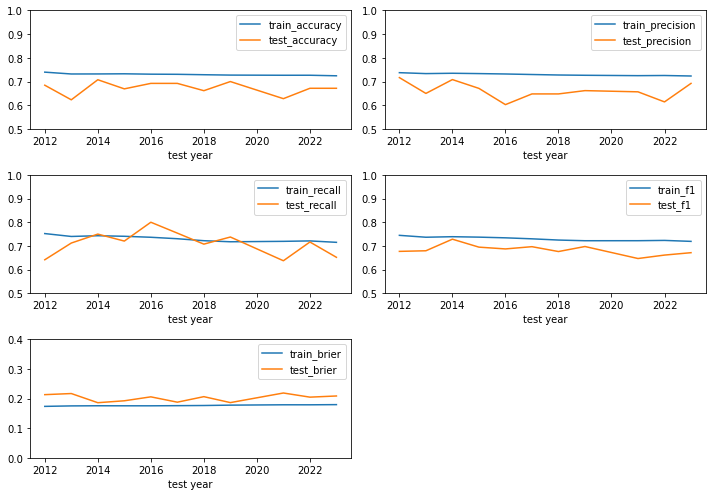

,metric,mean,std
0,fit_time,0.226,0.094
1,score_time,0.017,0.009
2,test_accuracy,0.673,0.026
3,train_accuracy,0.730,0.004
4,test_precision,0.661,0.034
5,train_precision,0.730,0.004
6,test_recall,0.712,0.048
7,train_recall,0.731,0.012
8,test_f1,0.684,0.020
9,train_f1,0.730,0.008


In [99]:
show_cv_results(cv_log_reg)

Observations: 
The training metrics remain constant along the different time windows. This can signal model underfiting. 


#### Decision Trees

In [102]:
param_distribs = {'decision_tree__max_depth': randint(low=3, high=10),
                  'decision_tree__max_leaf_nodes': randint(low=10, high=100),
                  'decision_tree__max_features': randint(low=20, high=len(X_train.columns)),
                 }

pipeline = Pipeline([("decision_tree", DecisionTreeClassifier(random_state=42))])
cv_tree_clf = RandomizedSearchCV(pipeline, param_distributions=param_distribs, n_iter=20, cv=IncrementalSeasonCV(seasons),
                   scoring=scoring, random_state=42,refit='brier')
cv_tree_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=IncrementalSeasonCV(day_column='DayNum', final_regular_day=132,
          season_column='Season',
          seasons=[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]),
                   estimator=Pipeline(steps=[('decision_tree',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_iter=20,
                   param_distributions={'decision_tree__max_depth': <scipy.stats._dist...
                                        'decision_tree__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016E22DCA430>,
                                        'decision_tree__max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016E22DCA2B0>},
                   random_state=42, refit='brier',
                   scoring={'accuracy': 'accuracy', 'brier': 'neg_brier_score',
                            'f1': 'f1', 'precision': 'precision',
                            'recall': 'recall'})

In [108]:
print(cv_tree_clf.best_params_)
print("Best Score: ", cv_tree_clf.best_score_)
#Note that the Brier score comes with a minus sign.

{'decision_tree__max_depth': 5, 'decision_tree__max_features': 41, 'decision_tree__max_leaf_nodes': 62}
Best Score:  -0.23006095755216177


#### Random Forest

In [105]:
param_distribs = {'rf__max_depth': randint(low=3, high=10),
                  'rf__max_leaf_nodes': randint(low=10, high=100),
                  'rf__max_features': randint(low=20, high=len(X_train.columns)),
                  'rf__n_estimators': np.arange(50,200,1)
                 }

forest = Pipeline([("rf", RandomForestClassifier(random_state=42))])
cv_forest_clf = RandomizedSearchCV(forest, param_distributions=param_distribs, n_iter=20, cv=IncrementalSeasonCV(seasons),
                   scoring=scoring, random_state=42,refit='brier', n_jobs=-1)
cv_forest_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=IncrementalSeasonCV(day_column='DayNum', final_regular_day=132,
          season_column='Season',
          seasons=[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]),
                   estimator=Pipeline(steps=[('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'rf__max_depth': <scipy.stats._distn_infrastruc...
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199])},
                   random_state=42, refit='brier',
                   scoring={'accuracy': 'accuracy', 'brier': 'neg_brier_score',
                            'f1': 'f1', 'precision': 'precision',
                            'recall': 'recall'})

In [107]:
print(cv_forest_clf.best_params_)
print("Best Score: ",cv_forest_clf.best_score_)

{'rf__max_depth': 9, 'rf__max_features': 54, 'rf__max_leaf_nodes': 87, 'rf__n_estimators': 130}
Best Score:  -0.21283599874598513


#### Gradient Boosting

In [109]:

param_distribs = {'gb__max_depth': randint(low=3, high=10),
                  'gb__max_leaf_nodes': randint(low=10, high=100),
                  'gb__max_features': randint(low=20, high=len(X_train.columns)),
                  'gb__learning_rate': [.001,.005,.01,.05,.1,.5],
                  'gb__n_estimators': np.arange(50,200,1)
                  
                 }

gb_clf = Pipeline([("gb",  GradientBoostingClassifier(n_iter_no_change=10, random_state=42))])
cv_gb_clf = RandomizedSearchCV(gb_clf, param_distributions=param_distribs, n_iter=20, cv=IncrementalSeasonCV(seasons),
                   scoring=scoring, random_state=42,refit='brier', n_jobs=-1)
cv_gb_clf.fit(X_train, y_train)
print(cv_gb_clf.best_params_)
print("Best Score: ", cv_gb_clf.best_score_)

{'gb__learning_rate': 0.05, 'gb__max_depth': 8, 'gb__max_features': 48, 'gb__max_leaf_nodes': 72, 'gb__n_estimators': 195}
Best Score:  -0.21263252016719097


### Evaluating on the test set

Logistic regression performs better, with a mean Brier score of 0.202.
Now we test on the test set.

In [111]:
log_reg = make_pipeline(StandardScaler(),  LogisticRegression(random_state=42, max_iter=200, penalty='l2'))
log_reg.fit( X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=200, random_state=42))])

In [112]:
print("Brier Score on test set", brier_score_loss(y_test, log_reg.predict_proba(X_test)[:,1]))

Brier Score on test set 0.20628220208067014


## Part 4: Final model and predictions

In [113]:
# We train the logistic model in the whole data set
train_set = dataset.query(f'DayNum > {cutday}').reset_index(drop=True)
log_reg = make_pipeline(StandardScaler(),  LogisticRegression(random_state=42, max_iter=200, penalty='l2'))
log_reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=200, random_state=42))])

We cannot predict upcoming games from our historical tables, since the tables only contain information about past games.
We now need to construct a table with hipotetical upcoming games in a neutral location, with their respective rolling averages. We can do these from similar queries from part 2.

In [114]:
window = 5

query = f"""

DROP TABLE IF EXISTS "RollingAvg{window}Current";
CREATE TEMP TABLE "RollingAvg{window}Current" AS

WITH  "teams" AS(
    SELECT DISTINCT "ATeamID" as "TeamID" 
    FROM "FullDetailedResultsMod"
    UNION
    SELECT DISTINCT "BTeamID" as "TeamID"
    FROM "FullDetailedResultsMod"
),

"t2" AS(
   SELECT 
        "ID",
        "Season" ,
        "DayNum" ,
        "ATeamID" ,
        "AScore" ,
        "AFGM" ,
        "AFGA" ,
        "AFGM3" ,
        "AFGA3" ,
        "AFTM" ,
        "AFTA" ,
        "AOR" ,
        "ADR" ,
        "AAst" ,
        "ATO" ,
        "AStl" ,
        "ABlk" ,
        "APF" ,
        "BTeamID" ,
        "BScore" ,
        "BFGM" ,
        "BFGA" ,
        "BFGM3" ,
        "BFGA3" ,
        "BFTM" ,
        "BFTA" ,
        "BOR" ,
        "BDR" ,
        "BAst" ,
        "BTO" ,
        "BStl" ,
        "BBlk" ,
        "BPF" ,
        "AHomeLoc" ,
        "AAwayLoc" ,
        "ANeutralLoc" ,
        "NumOT" ,
        "Genre" ,
        "Target"
   FROM "teams", LATERAL  fnGamesPlayedByTeam("teams"."TeamID")
   WHERE "Season" = 2025
)

SELECT DISTINCT ON ("ATeamID")
        "Season"     ,
        "DayNum"     ,
        "ATeamID"    ,
        "Genre", 
        AVG("AScore") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_AScore" ,
        AVG("AScore") OVER(PARTITION BY "Season", "ATeamID" ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) AS "AVG_ASeasonScore",
        SUM("Target") OVER(PARTITION BY "Season", "ATeamID" ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) AS "ASeasonWins",
        COUNT("Target") OVER(PARTITION BY "Season", "ATeamID" ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) AS "ASeasonPlayed",
        AVG("AFGM") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_AFGM"   ,
        AVG("AFGA") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_AFGA"   ,
        AVG("AFGM3") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_AFGM3"  ,
        AVG("AFGA3") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_AFGA3"  ,
        AVG("AFTM") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_AFTM"   ,
        AVG("AFTA") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_AFTA"   ,
        AVG("AOR") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_AOR"    ,
        AVG("ADR") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_ADR"    ,
        AVG("AAst") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_AAst"   ,
        AVG("ATO") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_ATO"    ,
        AVG("AStl") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_AStl"   ,
        AVG("ABlk") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_ABlk"   ,
        AVG("APF") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_APF"    ,
        AVG("Target") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_ATarget"    ,
        
        AVG("BScore") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BScore" ,
        AVG("BScore") OVER(PARTITION BY "Season", "ATeamID" ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) AS "AVG_BSeasonScore",  
        AVG("BFGM") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BFGM"   ,
        AVG("BFGA") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BFGA"   ,
        AVG("BFGM3") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BFGM3"  ,
        AVG("BFGA3") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BFGA3"  ,
        AVG("BFTM") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BFTM"   ,
        AVG("BFTA") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BFTA"   ,
        AVG("BOR") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BOR"    ,
        AVG("BDR") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING)  "AVG_BDR"    ,
        AVG("BAst") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BAst"  ,
        AVG("BTO") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BTO"   ,
        AVG("BStl") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BStl"   ,
        AVG("BBlk") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BBlk"   ,
        AVG("BPF") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_BPF",
        
        AVG("AHomeLoc") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_AHomeLoc"  , 
        AVG("AAwayLoc") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_AAwayLoc"  , 
        AVG("ANeutralLoc") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_ANeutralLoc"  , 
        "AHomeLoc"  , 
        "AAwayLoc" , 
        "ANeutralLoc", 
        AVG("NumOT") OVER(ORDER BY "ATeamID", "Season" DESC, "DayNum" DESC ROWS BETWEEN CURRENT ROW AND {window-1} FOLLOWING) "AVG_NumOT" 
        FROM "t2"
        ORDER BY "ATeamID" DESC, "DayNum" DESC 
"""
#pd.read_sql_query(query, engine)
with engine.begin() as conn:
    conn.execute(text(query))

In [115]:
query = """
    SELECT 
        concat_ws('_', "Season"::text, "t1"."ATeamID"::text, "t2"."ATeamID"::text) AS "ID",  
        "t1"."DayNum",  
        "t1"."Season",  
        "t1"."Genre",  
        "t1"."ATeamID"      AS "T1_ID",  
        "t1"."AHomeLoc" AS "T1_AHomeLoc", 
        "t1"."AAwayLoc" AS "T1_AAwayLoc", 
        "t1"."ANeutralLoc"    AS "T1_ANeutralLoc", 
        "t1"."AVG_AScore"   AS "AVG_T1_Score",  
        "t1"."AVG_ASeasonScore"   AS "AVG_T1_SeasonScore",  
        "t1"."ASeasonWins"   AS "T1_SeasonWins", 
        "t1"."ASeasonPlayed"   AS "T1_SeasonPlayed", 
        "t1"."AVG_AFGM"     AS "AVG_T1_FGM",  
        "t1"."AVG_AFGA"     AS "AVG_T1_FGA",  
        "t1"."AVG_AFGM3"    AS "AVG_T1_FGM3",  
        "t1"."AVG_AFGA3"    AS "AVG_T1_FGA3",  
        "t1"."AVG_AFTM"     AS "AVG_T1_FTM",  
        "t1"."AVG_AFTA"     AS "AVG_T1_FTA",  
        "t1"."AVG_AOR"      AS "AVG_T1_OR",  
        "t1"."AVG_ADR"      AS "AVG_T1_DR",  
        "t1"."AVG_AAst"     AS "AVG_T1_Ast",  
        "t1"."AVG_ATO"      AS "AVG_T1_TO",  
        "t1"."AVG_AStl"     AS "AVG_T1_Stl",  
        "t1"."AVG_ABlk"     AS "AVG_T1_Blk",  
        "t1"."AVG_APF"      AS "AVG_T1_PF",  
        "t1"."AVG_ATarget"  AS "AVG_T1_Wins",
        "t1"."AVG_AHomeLoc" AS "AVG_T1_AHomeLoc", 
        "t1"."AVG_AAwayLoc" AS "AVG_T1_AAwayLoc", 
        "t1"."AVG_ANeutralLoc"    AS "AVG_T1_ANeutralLoc", 

        "t1"."AVG_NumOT"    AS "AVG_T1_NumOT",  
        "t1"."AVG_BScore"   AS "AVG_T1c_Score",
        "t1"."AVG_BSeasonScore"   AS "AVG_T1c_SeasonScore",
        "t1"."AVG_BFGM"     AS "AVG_T1c_FGM",  
        "t1"."AVG_BFGA"     AS "AVG_T1c_FGA",  
        "t1"."AVG_BFGM3"    AS "AVG_T1c_FGM3",  
        "t1"."AVG_BFGA3"    AS "AVG_T1c_FGA3",  
        "t1"."AVG_BFTM"     AS "AVG_T1c_FTM",  
        "t1"."AVG_BFTA"     AS "AVG_T1c_FTA",  
        "t1"."AVG_BOR"      AS "AVG_T1c_OR",  
        "t1"."AVG_BDR"      AS "AVG_T1c_DR",  
        "t1"."AVG_BAst"     AS "AVG_T1c_Ast",  
        "t1"."AVG_BTO"      AS "AVG_T1c_TO",  
        "t1"."AVG_BStl"     AS "AVG_T1c_Stl",  
        "t1"."AVG_BBlk"     AS "AVG_T1c_Blk",  
        "t1"."AVG_BPF"      AS "AVG_T1c_PF",  


        "t2"."ATeamID"      AS "T2_ID",  
        "t2"."AVG_AScore"   AS "AVG_T2_Score",  
        "t2"."AVG_ASeasonScore"   AS "AVG_T2_SeasonScore", 
        "t2"."ASeasonWins"   AS "T2_SeasonWins",  
        "t2"."ASeasonPlayed"   AS "T2_SeasonPlayed", 
        "t2"."AVG_AFGM"     AS "AVG_T2_FGM",  
        "t2"."AVG_AFGA"     AS "AVG_T2_FGA",  
        "t2"."AVG_AFGM3"    AS "AVG_T2_FGM3",  
        "t2"."AVG_AFGA3"    AS "AVG_T2_FGA3",  
        "t2"."AVG_AFTM"     AS "AVG_T2_FTM",  
        "t2"."AVG_AFTA"     AS "AVG_T2_FTA",  
        "t2"."AVG_AOR"      AS "AVG_T2_OR",  
        "t2"."AVG_ADR"      AS "AVG_T2_DR",  
        "t2"."AVG_AAst"     AS "AVG_T2_Ast",  
        "t2"."AVG_ATO"      AS "AVG_T2_TO",  
        "t2"."AVG_AStl"     AS "AVG_T2_Stl",  
        "t2"."AVG_ABlk"     AS "AVG_T2_Blk",  
        "t2"."AVG_APF"      AS "AVG_T2_PF", 
        "t2"."AVG_ATarget"  AS "AVG_T2_Wins",
        "t2"."AVG_AHomeLoc"       AS "AVG_T2_AHomeLoc", 
        "t2"."AVG_AAwayLoc"       AS "AVG_T2_AAwayLoc", 
        "t2"."AVG_ANeutralLoc"    AS "AVG_T2_ANeutralLoc",  
        "t2"."AVG_NumOT"    AS "AVG_T2_NumOT",  
        "t2"."AVG_BScore"   AS "AVG_T2c_Score",  
        "t2"."AVG_BSeasonScore"   AS "AVG_T2c_SeasonScore",
        "t2"."AVG_BFGM"     AS "AVG_T2c_FGM",  
        "t2"."AVG_BFGA"     AS "AVG_T2c_FGA",  
        "t2"."AVG_BFGM3"    AS "AVG_T2c_FGM3",  
        "t2"."AVG_BFGA3"    AS "AVG_T2c_FGA3",  
        "t2"."AVG_BFTM"     AS "AVG_T2c_FTM",  
        "t2"."AVG_BFTA"     AS "AVG_T2c_FTA",  
        "t2"."AVG_BOR"      AS "AVG_T2c_OR",  
        "t2"."AVG_BDR"      AS "AVG_T2c_DR",  
        "t2"."AVG_BAst"     AS "AVG_T2c_Ast",  
        "t2"."AVG_BTO"      AS "AVG_T2c_TO",  
        "t2"."AVG_BStl"     AS "AVG_T2c_Stl",  
        "t2"."AVG_BBlk"     AS "AVG_T2c_Blk",  
        "t2"."AVG_BPF"      AS "AVG_T2c_PF"  
    FROM "RollingAvg5Current" "t1" JOIN "RollingAvg5Current" "t2" USING("Season", "Genre")
    WHERE "t1"."ATeamID" < "t2"."ATeamID" 
    ORDER BY "ID"  
    """

df_for_prediction = pd.read_sql_query(query, engine)


In [116]:
df2 = df_for_prediction.drop(["ID", "T1_ID", "T2_ID"], axis=1, inplace=False)
# Set all locations to neutral
df2["T1_AHomeLoc"] = 0
df2["T1_AAwayLoc"] = 0
df2["T1_ANeutralLoc"] = 1

#Predicting probabilities
probs = log_reg.predict_proba(df2)[:,1]
#Concatenating the probabilities with the games IDS
result = pd.concat([df_for_prediction["ID"], pd.DataFrame(probs, columns=["Pred"])], axis=1)

#Now we have the probabilities from hipotetical matches from teams which played in the 2025 season.
#In the competition we are asked to predict all the probabilities from all the possible teams combinations
# We give a probability of 0.5 for matchups where a team didn´t play in the 2025 season

m_index = list(range(1101,1481))
w_index = list(range(3101,3481))
ids_in_result = set([])
for txt in result["ID"].values:
    year  = int(txt.split('_')[1])
    ids_in_result.add(year)
ids_in_result.add(1480)
ids_in_result.add(3480)
ids_m_missing = set([])
for idx in m_index:
    if idx not in ids_in_result:
        ids_m_missing.add(idx)

ids_w_missing = set([])
for idx in w_index:
    if idx not in ids_in_result:
        ids_w_missing.add(idx)

missing_m =[ ['2025_'+str(i)+'_'+str(j),.5] if i<j else  ['2025_'+str(j)+'_'+ str(i),.5] if j<i else [] for i in ids_m_missing for j in m_index ]
missing_w =[ ['2025_'+str(i)+'_'+str(j),.5] if i<j else  ['2025_'+str(j)+'_'+ str(i),.5] if j<i else [] for i in ids_w_missing for j in w_index ]
missing = pd.DataFrame(missing_m+missing_w, columns=["ID","Pred"]).dropna()

result_full = pd.concat([result, pd.DataFrame(missing, columns=["ID","Pred"])])
result_full.sort_values(by=['ID'], inplace=True)
result_full.to_csv(project_path+'\\my_submision.csv', index=False)
print("My predicted probabilities:")
display(result_full)

My predicted probabilities:


,ID,Pred
0,2025_1101_1102,0.728040
1,2025_1101_1103,0.163499
2,2025_1101_1104,0.125804
3,2025_1101_1105,0.658141
4,2025_1101_1106,0.327347
...,...,...
131402,2025_3477_3479,0.357475
131403,2025_3477_3480,0.210134
131404,2025_3478_3479,0.374763
131405,2025_3478_3480,0.222767
